<a href="https://colab.research.google.com/github/ritwiks9635/My_Neural_Network_Architecture/blob/main/Large_scale_multi_label_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Large-scale multi-label text classification**

## Introduction

In this example, we will build a multi-label text classifier to predict the subject areas
of arXiv papers from their abstract bodies. This type of classifier can be useful for
conference submission portals like [OpenReview](https://openreview.net/). Given a paper
abstract, the portal could provide suggestions for which areas the paper would
best belong to.

The dataset was collected using the
[`arXiv` Python library](https://github.com/lukasschwab/arxiv.py)
that provides a wrapper around the
[original arXiv API](http://arxiv.org/help/api/index).
To learn more about the data collection process, please refer to
[this notebook](https://github.com/soumik12345/multi-label-text-classification/blob/master/arxiv_scrape.ipynb).
Additionally, you can also find the dataset on
[Kaggle](https://www.kaggle.com/spsayakpaul/arxiv-paper-abstracts).

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from ast import literal_eval
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

In [2]:
arxiv_data = pd.read_csv("https://github.com/soumik12345/multi-label-text-classification/releases/download/v0.2/arxiv_data.csv")
arxiv_data.head()

,titles,summaries,terms
0,Survey on Semantic Stereo Matching / Semantic ...,Stereo matching is one of the widely used tech...,"['cs.CV', 'cs.LG']"
1,FUTURE-AI: Guiding Principles and Consensus Re...,The recent advancements in artificial intellig...,"['cs.CV', 'cs.AI', 'cs.LG']"
2,Enforcing Mutual Consistency of Hard Regions f...,"In this paper, we proposed a novel mutual cons...","['cs.CV', 'cs.AI']"
3,Parameter Decoupling Strategy for Semi-supervi...,Consistency training has proven to be an advan...,['cs.CV']
4,Background-Foreground Segmentation for Interio...,"To ensure safety in automated driving, the cor...","['cs.CV', 'cs.LG']"


In [3]:
arxiv_data.titles[0]

'Survey on Semantic Stereo Matching / Semantic Depth Estimation'

In [4]:
arxiv_data.summaries[0]

'Stereo matching is one of the widely used techniques for inferring depth from\nstereo images owing to its robustness and speed. It has become one of the major\ntopics of research since it finds its applications in autonomous driving,\nrobotic navigation, 3D reconstruction, and many other fields. Finding pixel\ncorrespondences in non-textured, occluded and reflective areas is the major\nchallenge in stereo matching. Recent developments have shown that semantic cues\nfrom image segmentation can be used to improve the results of stereo matching.\nMany deep neural network architectures have been proposed to leverage the\nadvantages of semantic segmentation in stereo matching. This paper aims to give\na comparison among the state of art networks both in terms of accuracy and in\nterms of speed which are of higher importance in real-time applications.'

Our text features are present in the `summaries` column and their corresponding labels
are in `terms`. As you can notice, there are multiple categories associated with a
particular entry.

In [5]:
arxiv_data.shape

(51774, 3)

Real-world data is noisy. One of the most commonly observed source of noise is data
duplication. Here we notice that our initial dataset has got about 13k duplicate entries.

In [6]:
total_duplicate_titles = sum(arxiv_data["titles"].duplicated())
print(f"There are {total_duplicate_titles} duplicate titles.")

There are 12802 duplicate titles.


Before proceeding further, we drop these entries.

In [7]:
arxiv_data = arxiv_data[~arxiv_data["titles"].duplicated()]
print(f"There are {len(arxiv_data)} rows in the deduplicated dataset.")

# There are some terms with occurrence as low as 1.
print(sum(arxiv_data["terms"].value_counts() == 1))

# How many unique terms?
print(arxiv_data["terms"].nunique())

There are 38972 rows in the deduplicated dataset.
2321
3157


In [8]:
arxiv_data.shape

(38972, 3)

As observed above, out of 3,157 unique combinations of `terms`, 2,321 entries have the
lowest occurrence. To prepare our train, validation, and test sets with
[stratification](https://en.wikipedia.org/wiki/Stratified_sampling), we need to drop
these terms.

In [9]:
arxiv_data_filterd = arxiv_data.groupby("terms").filter(lambda x : len(x) > 1)
arxiv_data_filterd.shape

(36651, 3)

## Convert the string labels to lists of strings

The initial labels are represented as raw strings. Here we make them `List[str]` for a
more compact representation.

In [10]:
arxiv_data_filterd["terms"] = arxiv_data_filterd["terms"].apply(lambda x : literal_eval(x))
arxiv_data_filterd["terms"].values[:5]

array([list(['cs.CV', 'cs.LG']), list(['cs.CV', 'cs.AI', 'cs.LG']),
       list(['cs.CV', 'cs.AI']), list(['cs.CV']),
       list(['cs.CV', 'cs.LG'])], dtype=object)

## Use stratified splits because of class imbalance

The dataset has a
[class imbalance problem](https://developers.google.com/machine-learning/glossary/#class-imbalanced-dataset).
So, to have a fair evaluation result, we need to ensure the datasets are sampled with
stratification. To know more about different strategies to deal with the class imbalance
problem, you can follow
[this tutorial](https://www.tensorflow.org/tutorials/structured_data/imbalanced_data).
For an end-to-end demonstration of classification with imbablanced data, refer to
[Imbalanced classification: credit card fraud detection](https://keras.io/examples/structured_data/imbalanced_classification/).

In [11]:
test_split = 0.1

# Initial train and test split.
train_df, test_df = train_test_split(
    arxiv_data_filterd,
    test_size=test_split,
    stratify=arxiv_data_filterd["terms"].values)

# Splitting the test set further into validation
# and new test sets.
val_df = test_df.sample(frac=0.5)
test_df.drop(val_df.index, inplace=True)

print(f"Number of rows in training set: {len(train_df)}")
print(f"Number of rows in validation set: {len(val_df)}")
print(f"Number of rows in test set: {len(test_df)}")

Number of rows in training set: 32985
Number of rows in validation set: 1833
Number of rows in test set: 1833


## Multi-label binarization

Now we preprocess our labels using the
[`StringLookup`](https://keras.io/api/layers/preprocessing_layers/categorical/string_lookup)
layer.

In [12]:
terms = tf.ragged.constant(train_df["terms"].values)
lookup = tf.keras.layers.StringLookup(output_mode="multi_hot")
lookup.adapt(terms)
vocab = lookup.get_vocabulary()


def invert_multi_hot(encoded_labels):
    """Reverse a single multi-hot encoded label to a tuple of vocab terms."""
    hot_indices = np.argwhere(encoded_labels == 1.0)[..., 0]
    return np.take(vocab, hot_indices)


print("Vocabulary:\n")
print(vocab)

Vocabulary:

['[UNK]', 'cs.CV', 'cs.LG', 'stat.ML', 'cs.AI', 'eess.IV', 'cs.RO', 'cs.CL', 'cs.NE', 'cs.CR', 'math.OC', 'eess.SP', 'cs.GR', 'cs.SI', 'cs.MM', 'cs.SY', 'cs.IR', 'cs.MA', 'eess.SY', 'cs.HC', 'math.IT', 'cs.IT', 'cs.DC', 'cs.CY', 'stat.AP', 'stat.TH', 'math.ST', 'stat.ME', 'eess.AS', 'cs.SD', 'q-bio.QM', 'q-bio.NC', 'cs.DS', 'cs.GT', 'cs.CG', 'cs.SE', 'cs.NI', 'I.2.6', 'stat.CO', 'math.NA', 'cs.NA', 'physics.chem-ph', 'cs.DB', 'q-bio.BM', 'cs.LO', 'cs.PL', 'cond-mat.dis-nn', '68T45', 'math.PR', 'physics.comp-ph', 'I.2.10', 'cs.CE', 'cs.AR', 'q-fin.ST', 'cond-mat.stat-mech', 'math.DS', 'cs.CC', '68T05', 'quant-ph', 'physics.data-an', 'I.4.6', 'physics.soc-ph', 'physics.ao-ph', 'cs.DM', 'q-bio.GN', 'econ.EM', 'physics.med-ph', 'astro-ph.IM', 'I.4.8', 'math.AT', 'cs.PF', 'cs.FL', 'I.4', 'q-fin.TR', 'I.5.4', 'I.2', '68U10', 'physics.geo-ph', 'hep-ex', '68T10', 'physics.optics', 'cond-mat.mtrl-sci', 'physics.flu-dyn', 'math.AP', 'I.4; I.5', 'I.4.9', 'I.2.6; I.2.8', 'I.2.10; I.4;

Here we are separating the individual unique classes available from the label
pool and then using this information to represent a given label set with 0's and 1's.
Below is an example.

In [13]:
sample_label = train_df["terms"].iloc[0]
print(f"Original label: {sample_label}")

label_binarized = lookup([sample_label])
print(f"Label-binarized representation: {label_binarized}")

Original label: ['cs.LG', 'cs.DS', 'stat.ML']
Label-binarized representation: [[0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0.]]


## Data preprocessing and `tf.data.Dataset` objects

We first get percentile estimates of the sequence lengths. The purpose will be clear in a
moment.

In [14]:
train_df["summaries"].apply(lambda x : len(x.split(" "))).describe()

count    32985.000000
mean       156.564590
std         41.478356
min          5.000000
25%        128.000000
50%        155.000000
75%        183.000000
max        462.000000
Name: summaries, dtype: float64

Notice that 50% of the abstracts have a length of 154 (you may get a different number
based on the split). So, any number close to that value is a good enough approximate for the
maximum sequence length.

Now, we implement utilities to prepare our datasets.

In [15]:
max_seqlen = 150
batch_size = 128
padding_token = "<pad>"
auto = tf.data.AUTOTUNE


def make_dataset(dataframe, is_train=True):
    labels = tf.ragged.constant(dataframe["terms"].values)
    label_binarized = lookup(labels).numpy()
    dataset = tf.data.Dataset.from_tensor_slices(
        (dataframe["summaries"].values, label_binarized))
    dataset = dataset.shuffle(batch_size * 10) if is_train else dataset
    return dataset.batch(batch_size)

In [16]:
train_dataset = make_dataset(train_df, is_train = True)
test_dataset = make_dataset(test_df, is_train = False)
val_dataset = make_dataset(val_df, is_train = False)

In [17]:
text_batch, label_batch = next(iter(train_dataset))

for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Abstract: {text}")
    print(f"Label(s): {invert_multi_hot(label[0])}")
    print(" ")

Abstract: b'The explore{exploit dilemma is one of the central challenges in Reinforcement\nLearning (RL). Bayesian RL solves the dilemma by providing the agent with\ninformation in the form of a prior distribution over environments; however,\nfull Bayesian planning is intractable. Planning with the mean MDP is a common\nmyopic approximation of Bayesian planning. We derive a novel reward bonus that\nis a function of the posterior distribution over environments, which, when\nadded to the reward in planning with the mean MDP, results in an agent which\nexplores efficiently and effectively. Although our method is similar to\nexisting methods when given an uninformative or unstructured prior, unlike\nexisting methods, our method can exploit structured priors. We prove that our\nmethod results in a polynomial sample complexity and empirically demonstrate\nits advantages in a structured exploration task.'
Label(s): ['cs.LG' 'stat.ML' 'cs.AI']
 
Abstract: b'Bayesian reinforcement learning (BRL

## Vectorization

Before we feed the data to our model, we need to vectorize it (represent it in a numerical form).
For that purpose, we will use the
[`TextVectorization` layer](https://keras.io/api/layers/preprocessing_layers/text/text_vectorization).
It can operate as a part of your main model so that the model is excluded from the core
preprocessing logic. This greatly reduces the chances of training / serving skew during inference.

We first calculate the number of unique words present in the abstracts.

In [18]:
# Source: https://stackoverflow.com/a/18937309/7636462
vocabulary = set()
train_df["summaries"].str.lower().str.split().apply(vocabulary.update)
vocabulary_size = len(vocabulary)
print(vocabulary_size)

153162


In [19]:
text_vectorizer = layers.TextVectorization(
    max_tokens=vocabulary_size, ngrams=2, output_mode="tf_idf")

# `TextVectorization` layer needs to be adapted as per the vocabulary from our
# training set.
with tf.device("/CPU:0"):
    text_vectorizer.adapt(train_dataset.map(lambda text, label: text))

train_dataset = train_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
validation_dataset = val_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
test_dataset = test_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)

A batch of raw text will first go through the `TextVectorization` layer and it will
generate their integer representations. Internally, the `TextVectorization` layer will
first create bi-grams out of the sequences and then represent them using
[TF-IDF](https://wikipedia.org/wiki/Tf%E2%80%93idf). The output representations will then
be passed to the shallow model responsible for text classification.

To learn more about other possible configurations with `TextVectorizer`, please consult
the
[official documentation](https://keras.io/api/layers/preprocessing_layers/text/text_vectorization).

**Note**: Setting the `max_tokens` argument to a pre-calculated vocabulary size is
not a requirement.



## Create a text classification model

We will keep our model simple -- it will be a small stack of fully-connected layers with
ReLU as the non-linearity.

In [20]:
def make_model():
    shallow_mlp_model = keras.Sequential(
        [
            layers.Dense(512, activation="relu"),
            layers.Dense(256, activation="relu"),
            layers.Dense(lookup.vocabulary_size(), activation="sigmoid"),
        ]  # More on why "sigmoid" has been used here in a moment.
    )
    return shallow_mlp_model

## Train the model

We will train our model using the binary crossentropy loss. This is because the labels
are not disjoint. For a given abstract, we may have multiple categories. So, we will
divide the prediction task into a series of multiple binary classification problems. This
is also why we kept the activation function of the classification layer in our model to
sigmoid. Researchers have used other combinations of loss function and activation
function as well. For example, in [Exploring the Limits of Weakly Supervised Pretraining](https://arxiv.org/abs/1805.00932),
Mahajan et al. used the softmax activation function and cross-entropy loss to train
their models.

There are several options of metrics that can be used in multi-label classification.
To keep this code example narrow we decided to use the
[binary accuracy metric](https://keras.io/api/metrics/accuracy_metrics/#binaryaccuracy-class).
To see the explanation why this metric is used we refer to this
[pull-request](https://github.com/keras-team/keras-io/pull/1133#issuecomment-1322736860).
There are also other suitable metrics for multi-label classification, like
[F1 Score](https://www.tensorflow.org/addons/api_docs/python/tfa/metrics/F1Score) or
[Hamming loss](https://www.tensorflow.org/addons/api_docs/python/tfa/metrics/HammingLoss).

Epoch 1/20
258/258 [==============================] - 27s 84ms/step - loss: 0.0316 - binary_accuracy: 0.9899 - val_loss: 0.0189 - val_binary_accuracy: 0.9941
Epoch 2/20
258/258 [==============================] - 22s 83ms/step - loss: 0.0031 - binary_accuracy: 0.9991 - val_loss: 0.0270 - val_binary_accuracy: 0.9938
Epoch 3/20
258/258 [==============================] - 24s 95ms/step - loss: 8.1023e-04 - binary_accuracy: 0.9998 - val_loss: 0.0329 - val_binary_accuracy: 0.9934
Epoch 4/20
258/258 [==============================] - 20s 78ms/step - loss: 3.8977e-04 - binary_accuracy: 0.9999 - val_loss: 0.0370 - val_binary_accuracy: 0.9939
Epoch 5/20
258/258 [==============================] - 23s 90ms/step - loss: 2.0005e-04 - binary_accuracy: 1.0000 - val_loss: 0.0398 - val_binary_accuracy: 0.9939
Epoch 6/20
258/258 [==============================] - 22s 86ms/step - loss: 1.0975e-04 - binary_accuracy: 1.0000 - val_loss: 0.0417 - val_binary_accuracy: 0.9939
Epoch 7/20
258/258 [================

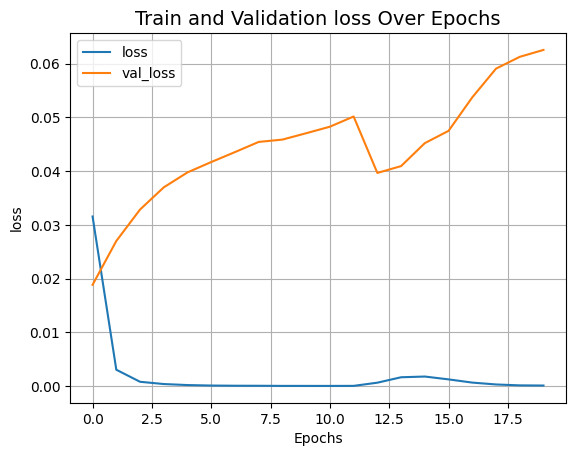

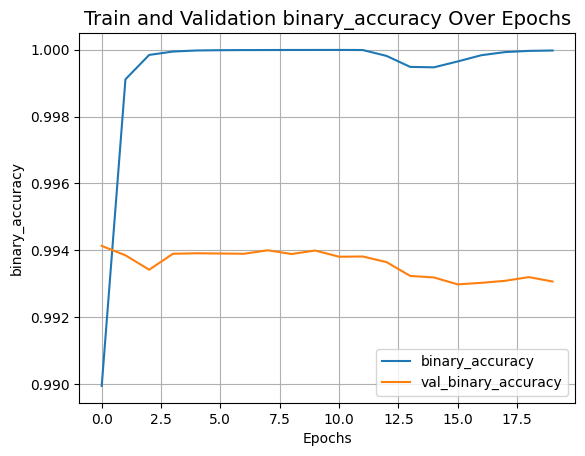

In [21]:
shallow_mlp_model = make_model()
shallow_mlp_model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["binary_accuracy"])

history = shallow_mlp_model.fit(
    train_dataset, validation_data=validation_dataset, epochs=20)


def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("binary_accuracy")

In [22]:
_, binary_acc = shallow_mlp_model.evaluate(test_dataset)
print(f"Categorical accuracy on the test set: {round(binary_acc * 100, 2)}%.")

15/15 [==============================] - 1s 85ms/step - loss: 0.0585 - binary_accuracy: 0.9932
Categorical accuracy on the test set: 99.32%.


## Inference

An important feature of the
[preprocessing layers provided by Keras](https://keras.io/guides/preprocessing_layers/)
is that they can be included inside a `tf.keras.Model`. We will export an inference model
by including the `text_vectorization` layer on top of `shallow_mlp_model`. This will
allow our inference model to directly operate on raw strings.

**Note** that during training it is always preferable to use these preprocessing
layers as a part of the data input pipeline rather than the model to avoid
surfacing bottlenecks for the hardware accelerators. This also allows for
asynchronous data processing.

In [23]:
# Create a model for inference.
model_for_inference = keras.Sequential([text_vectorizer, shallow_mlp_model])

# Create a small dataset just for demoing inference.
inference_dataset = make_dataset(test_df.sample(100), is_train=False)
text_batch, label_batch = next(iter(inference_dataset))
predicted_probabilities = model_for_inference.predict(text_batch)

# Perform inference.
for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Abstract: {text}")
    print(f"Label(s): {invert_multi_hot(label[0])}")
    predicted_proba = [proba for proba in predicted_probabilities[i]]
    top_3_labels = [
        x
        for _, x in sorted(
            zip(predicted_probabilities[i], lookup.get_vocabulary()),
            key=lambda pair: pair[0],
            reverse=True,
        )
    ][:3]
    print(f"Predicted Label(s): ({', '.join([label for label in top_3_labels])})")
    print(" ")

4/4 [==============================] - 1s 8ms/step
Abstract: b'Medical images are naturally associated with rich semantics about the human\nanatomy, reflected in an abundance of recurring anatomical patterns, offering\nunique potential to foster deep semantic representation learning and yield\nsemantically more powerful models for different medical applications. But how\nexactly such strong yet free semantics embedded in medical images can be\nharnessed for self-supervised learning remains largely unexplored. To this end,\nwe train deep models to learn semantically enriched visual representation by\nself-discovery, self-classification, and self-restoration of the anatomy\nunderneath medical images, resulting in a semantics-enriched, general-purpose,\npre-trained 3D model, named Semantic Genesis. We examine our Semantic Genesis\nwith all the publicly-available pre-trained models, by either self-supervision\nor fully supervision, on the six distinct target tasks, covering both\nclassific

The prediction results are not that great but not below the par for a simple model like
ours. We can improve this performance with models that consider word order like LSTM or
even those that use Transformers ([Vaswani et al.](https://arxiv.org/abs/1706.03762)).



## Acknowledgements

We would like to thank [Matt Watson](https://github.com/mattdangerw) for helping us
tackle the multi-label binarization part and inverse-transforming the processed labels
to the original form.

Thanks to [Cingis Kratochvil](https://github.com/cumbalik) for suggesting and extending this code example by introducing binary accuracy as the evaluation metric.